# Setup

In [ ]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from transformers import TrainerCallback
from tokenizers import BertWordPieceTokenizer

from tqdm import tqdm
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nnvegetarian
from transformers import AutoModel
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

import os
from pathlib import Path

vegetarian
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "0"  # Replace "0" with the device ID you want to use
)

In [20]:
def plot_loss(trainer, model_version):
    # 取得したログから loss を抽出
    log_history = trainer.state.log_history

    # ログデータを DataFrame に変換
    df_logs = pd.DataFrame(log_history)

    # train loss のみを抽出
    df_train_loss = df_logs[df_logs["loss"].notna()][["step", "loss"]]

    # valid loss (eval_loss) のみを抽出
    df_valid_loss = df_logs[df_logs["eval_loss"].notna()][
        ["step", "eval_loss"]
    ]

    # グラフのプロット
    plt.figure(figsize=(10, 5))
    plt.plot(
        df_train_loss["step"],
        df_train_loss["loss"],
        label="Train Loss",
        marker="o",
        linestyle="dashed",
    )
    plt.plot(
        df_valid_loss["step"],
        df_valid_loss["eval_loss"],
        label="Validation Loss",
        marker="s",
        linestyle="dashed",
    )
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Step")
    plt.legend()
    plt.grid()
    plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16500 [00:00<?, ? examples/s]

/home/matthieu/anaconda3/envs/stat528/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1862770/459172890.py:152: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training started: 6600 steps in total.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.365700,0.363244,0.851212
2,0.307500,0.317566,0.856667
3,0.242000,0.367952,0.859091
4,0.209700,0.386373,0.863939
5,0.136900,0.512792,0.860606
6,0.082900,0.688114,0.862424
7,0.033600,0.836803,0.858485
8,0.020600,0.897073,0.862121


Step 100/6600, Loss: 0.5705
Step 200/6600, Loss: 0.4069
Step 300/6600, Loss: 0.3709
Step 400/6600, Loss: 0.3635
Step 500/6600, Loss: 0.3403
Step 600/6600, Loss: 0.3703
Step 700/6600, Loss: 0.3565
Step 800/6600, Loss: 0.3657
Step 900/6600, Loss: 0.3253
Step 1000/6600, Loss: 0.3056
Step 1100/6600, Loss: 0.3168
Step 1200/6600, Loss: 0.3021
Step 1300/6600, Loss: 0.2936
Step 1400/6600, Loss: 0.3077
Step 1500/6600, Loss: 0.2979
Step 1600/6600, Loss: 0.3075
Step 1700/6600, Loss: 0.2786
Step 1800/6600, Loss: 0.2346
Step 1900/6600, Loss: 0.2591
Step 2000/6600, Loss: 0.2367
Step 2100/6600, Loss: 0.2639
Step 2200/6600, Loss: 0.2609
Step 2300/6600, Loss: 0.2547
Step 2400/6600, Loss: 0.2420
Step 2500/6600, Loss: 0.2511
Step 2600/6600, Loss: 0.1699
Step 2700/6600, Loss: 0.1860
Step 2800/6600, Loss: 0.1926
Step 2900/6600, Loss: 0.1719
Step 3000/6600, Loss: 0.1691
Step 3100/6600, Loss: 0.2082
Step 3200/6600, Loss: 0.2009
Step 3300/6600, Loss: 0.2097
Step 3400/6600, Loss: 0.1166
Step 3500/6600, Loss: 0

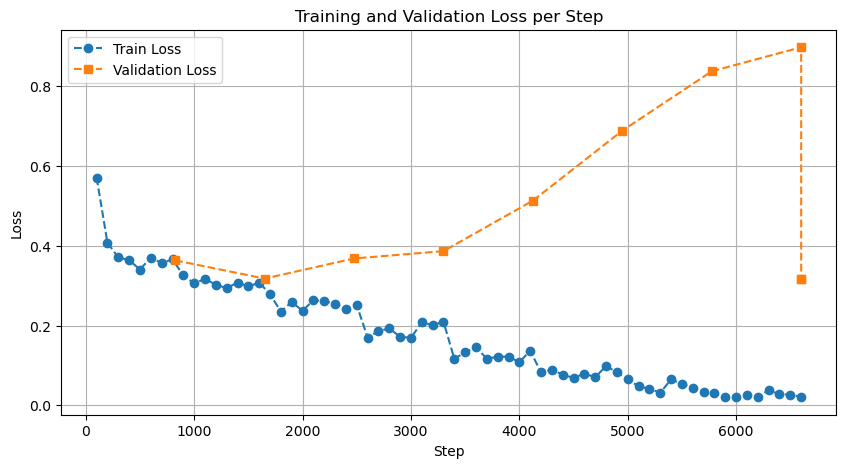

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
model_version = "subm2_2"
output_dir = f"./{model_version}/checkpoints"
model_path = f"./{model_version}/model"
subm_path = f"./{model_version}/submission.csv"

VOCAB_SIZE = 30522
MIN_FREQUENCY = 2


def make_dataset(df, train=True):
    # Load tokenizer to get the separator token
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    sep_token = tokenizer.sep_token

    # Convert list of strings in 'ingredients' column to a single string
    df["ingredients"] = df["ingredients"].apply(
        lambda x: sep_token.join(eval(x)) if isinstance(x, str) else ""  # type: ignore
    )

    # Fill NaN values in 'description' with an empty string
    df["description"] = df["description"].fillna("")

    # Combine text columns with a separator
    def make_text(row):
        return f"""
    Name: {row['name']}
    {sep_token}
    Description: {row['description']}
    {sep_token}
    Ingredients: {row['ingredients']}
        """

    df["text"] = df.apply(make_text, axis=1)

    if train:
        # Convert boolean target column into 0/1 format
        df["vegetarian"] = df["vegetarian"].astype(int)

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df[["text", "vegetarian"]])
    else:
        dataset = Dataset.from_pandas(df[["text"]])

    return dataset


file_path = "/kaggle/input/win25-stat-528-kaggle-competition-1/train.csv"
df = pd.read_csv(file_path)

dataset = make_dataset(df)


# Step 2: Load Pre-trained DistilBERT Model and Tokenizer
model_name = "distilbert-base-uncased"
# model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2
)


def tokenize_dataset(dataset, train=True):
    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=512,
        )

    # Tokenize dataset
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(
        ["text"]
    )  # Remove raw text
    if train:
        tokenized_dataset = tokenized_dataset.rename_column(
            "vegetarian", "labels"
        )  # Rename label column
    tokenized_dataset.set_format("torch")

    return tokenized_dataset


def make_submission(trainer, save_path):
    file_path = "/kaggle/input/win25-stat-528-kaggle-competition-1/test.csv"
    test_df = pd.read_csv(file_path)
    test_dataset = make_dataset(test_df, train=False)
    tokenized_test_dataset = tokenize_dataset(test_dataset, train=False)

    predictions = trainer.predict(tokenized_test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=-1)

    test_df["vegetarian"] = predicted_labels

    test_df[["id", "vegetarian"]].to_csv(save_path, index=False)


tokenized_dataset = tokenize_dataset(dataset)


# Split into train/test
split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
eval_dataset = split["test"]


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}


# --- Step 2: Define Training Callback for tqdm Progress Bar ---
class ProgressCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        print(f"Training started: {state.max_steps} steps in total.")

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Logs progress every 10 steps."""
        if logs is not None and "loss" in logs:
            tqdm.write(
                f"Step {state.global_step}/{state.max_steps}, Loss: {logs['loss']:.4f}"
            )


# --- Step 3: Define Training Arguments with Logging and TensorBoard Support ---
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.06,
    logging_dir="./logs",
    logging_steps=100,
    report_to=["tensorboard"],
    save_total_limit=2,
    push_to_hub=False,
)

# --- Step 4: Initialize Trainer with Callback ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[ProgressCallback()],  # Custom progress callback
)

# --- Step 5: Train the Model ---
trainer.train()

# --- Step 6: Evaluate Model ---
trainer.evaluate()

# --- Step 7: Save Fine-tuned Model ---
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

trainer.evaluate()

plot_loss(trainer, model_version)

make_submission(trainer, subm_path)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.3587111532688141,
 'eval_accuracy': 0.8524242424242424,
 'eval_runtime': 11.8772,
 'eval_samples_per_second': 277.844,
 'eval_steps_per_second': 34.773,
 'epoch': 3.0}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.





{'original_text': 'never put pineapple on a pizza', 'tokenized_words': ['never', 'put', 'pineapple', 'on', 'a', 'pizza'], 'token_ids': [2, 1353, 1122, 1192, 170, 41, 750, 3], 'decoded_text': 'never put pineapple on a pizza'}


Map:   0%|          | 0/16500 [00:00<?, ? examples/s]

/home/matthieu/anaconda3/envs/stat528/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1862770/3285193336.py:208: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training started: 13200 steps in total.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.520900,0.487934,0.827576
2,0.421000,0.432888,0.842424
3,0.382100,0.397564,0.851212
4,0.333000,0.386544,0.855758
5,0.306500,0.380014,0.851818
6,0.276300,0.377985,0.849394
7,0.254400,0.376515,0.852121
8,0.246700,0.378072,0.849697


Step 100/13200, Loss: 0.6975
Step 200/13200, Loss: 0.6903
Step 300/13200, Loss: 0.6877
Step 400/13200, Loss: 0.6757
Step 500/13200, Loss: 0.6577
Step 600/13200, Loss: 0.6402
Step 700/13200, Loss: 0.6202
Step 800/13200, Loss: 0.5962
Step 900/13200, Loss: 0.5808
Step 1000/13200, Loss: 0.5730
Step 1100/13200, Loss: 0.5561
Step 1200/13200, Loss: 0.5617
Step 1300/13200, Loss: 0.5358
Step 1400/13200, Loss: 0.5260
Step 1500/13200, Loss: 0.5225
Step 1600/13200, Loss: 0.5209
Step 1700/13200, Loss: 0.4927
Step 1800/13200, Loss: 0.4703
Step 1900/13200, Loss: 0.4580
Step 2000/13200, Loss: 0.4771
Step 2100/13200, Loss: 0.4698
Step 2200/13200, Loss: 0.4647
Step 2300/13200, Loss: 0.4517
Step 2400/13200, Loss: 0.4558
Step 2500/13200, Loss: 0.4652
Step 2600/13200, Loss: 0.4447
Step 2700/13200, Loss: 0.4434
Step 2800/13200, Loss: 0.4301
Step 2900/13200, Loss: 0.4261
Step 3000/13200, Loss: 0.4301
Step 3100/13200, Loss: 0.4614
Step 3200/13200, Loss: 0.4309
Step 3300/13200, Loss: 0.4210
Step 3400/13200, Lo

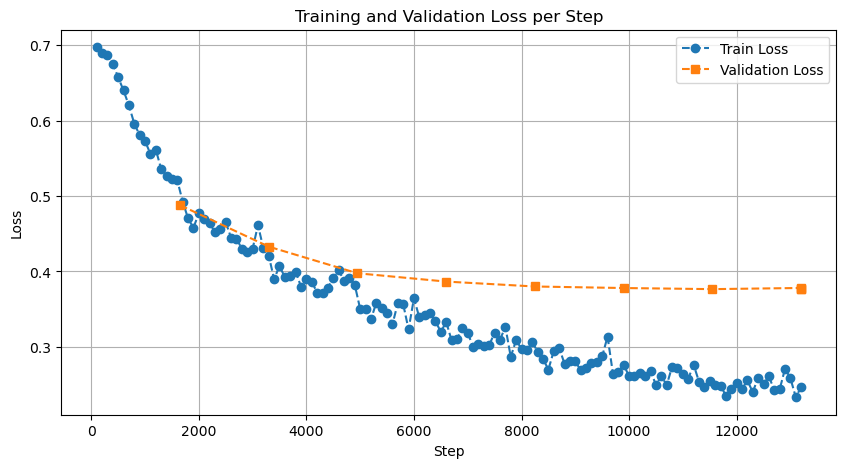

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
model_version = "subm2_newtokenizer"
output_dir = f"./{model_version}/checkpoints"
model_path = f"./{model_version}/model"
subm_path = f"./{model_version}/submission.csv"

VOCAB_SIZE = 30522
MIN_FREQUENCY = 2


def make_dataset(
    df,
    train=True,
):
    # Load tokenizer to get the separator token
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    sep_token = tokenizer.sep_token

    # Convert list of strings in 'ingredients' column to a single string
    df["ingredients"] = df["ingredients"].apply(
        lambda x: sep_token.join(eval(x)) if isinstance(x, str) else ""  # type: ignore
    )

    # Fill NaN values in 'description' with an empty string
    df["description"] = df["description"].fillna("")

    # Combine text columns with a separator
    def make_text(row):
        return f"""
    Name: {row['name']}
    {sep_token}
    Description: {row['description']}
    {sep_token}
    Ingredients: {row['ingredients']}
        """

    df["text"] = df.apply(make_text, axis=1)

    # df["text"] = "Ingredients: " + df["ingredients"]

    if train:
        # Convert boolean target column into 0/1 format
        df["vegetarian"] = df["vegetarian"].astype(int)

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df[["text", "vegetarian"]])
    else:
        dataset = Dataset.from_pandas(df[["text"]])

    return dataset


# Step 1: Load Your Custom Dataset
file_path = "/kaggle/input/win25-stat-528-kaggle-competition-1/train.csv"
df = pd.read_csv(file_path)

dataset = make_dataset(df)


# Step 2: Load Pre-trained DistilBERT Model and Tokenizer
model_name = "distilbert-base-uncased"
# model_name = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2
)


def get_new_tokenizer():
    temp_file = Path("temp_tokenizer_train.txt")
    with temp_file.open("r", encoding="utf-8") as f:
        corpus = f.read().splitlines()

    # Train a new tokenizer using the Hugging Face Tokenizers library
    old_tokenizer = AutoTokenizer.from_pretrained(model_name)
    new_tokenizer = old_tokenizer.train_new_from_iterator(corpus, vocab_size=30520)  # type: ignore
    return new_tokenizer


tokenizer = get_new_tokenizer()

for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

for param in model.distilbert.embeddings.parameters():
    param.requires_grad = True


def tokenize_and_decode(text):
    """Tokenizes input text, prints token IDs, and decodes them back to text."""

    # Tokenize the input text
    encoded = tokenizer(text, return_tensors="pt")

    # Extract token IDs
    token_ids = encoded["input_ids"][0].tolist()  # type: ignore

    # Decode back to text
    decoded_text = tokenizer.decode(token_ids, skip_special_tokens=True)

    return {
        "original_text": text,
        "tokenized_words": tokenizer.tokenize(text),
        "token_ids": token_ids,
        "decoded_text": decoded_text,
    }


print(tokenize_and_decode("never put pineapple on a pizza"))


def tokenize_dataset(dataset, train=True):
    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=512,
        )

    # Tokenize dataset
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(
        ["text"]
    )  # Remove raw text
    if train:
        tokenized_dataset = tokenized_dataset.rename_column(
            "vegetarian", "labels"
        )  # Rename label column
    tokenized_dataset.set_format("torch")

    return tokenized_dataset


def make_submission(trainer, save_path):
    file_path = "/kaggle/input/win25-stat-528-kaggle-competition-1/test.csv"
    test_df = pd.read_csv(file_path)
    test_dataset = make_dataset(test_df, train=False)
    tokenized_test_dataset = tokenize_dataset(test_dataset, train=False)

    predictions = trainer.predict(tokenized_test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=-1)

    test_df["vegetarian"] = predicted_labels

    test_df[["id", "vegetarian"]].to_csv(save_path, index=False)


tokenized_dataset = tokenize_dataset(dataset)


# Split into train/test
split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
eval_dataset = split["test"]


# Split into train/test
split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
eval_dataset = split["test"]


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}


# --- Step 2: Define Training Callback for tqdm Progress Bar ---
class ProgressCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        print(f"Training started: {state.max_steps} steps in total.")

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Logs progress every 10 steps."""
        if logs is not None and "loss" in logs:
            tqdm.write(
                f"Step {state.global_step}/{state.max_steps}, Loss: {logs['loss']:.4f}"
            )


# --- Step 3: Define Training Arguments with Logging and TensorBoard Support ---
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,  # 最も良いモデルをロード
    metric_for_best_model="eval_loss",  # 評価指標として eval_loss を使用
    greater_is_better=False,  # loss は小さい方が良い
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    # num_train_epochs=1,
    weight_decay=0.32,
    logging_dir="./logs",  # For TensorBoard
    logging_steps=100,
    report_to=["tensorboard"],  # Log to TensorBoard
    save_total_limit=2,  # Keep only the last 2 checkpoints
    push_to_hub=False,
)

model.resize_token_embeddings(len(tokenizer))


# --- Step 4: Initialize Trainer with Callback ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[ProgressCallback()],  # Custom progress callback
)

# --- Step 5: Train the Model ---
trainer.train()

# --- Step 6: Evaluate Model ---
trainer.evaluate()

# --- Step 7: Save Fine-tuned Model ---
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

trainer.evaluate()

plot_loss(trainer, model_version)

make_submission(trainer, subm_path)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.





{'original_text': 'never put pineapple on a pizza', 'tokenized_words': ['never', 'put', 'pineapple', 'on', 'a', 'pizza'], 'token_ids': [2, 1353, 1122, 1192, 170, 41, 750, 3], 'decoded_text': 'never put pineapple on a pizza'}


Map:   0%|          | 0/16500 [00:00<?, ? examples/s]

/home/matthieu/anaconda3/envs/stat528/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1862770/1941949202.py:207: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training started: 6600 steps in total.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.486800,0.441366,0.808182
2,0.441500,0.415313,0.832727
3,0.360600,0.388519,0.841515
4,0.273300,0.353181,0.845758
5,0.234200,0.434853,0.846061
6,0.189700,0.519151,0.843030
7,0.167300,0.595334,0.839091
8,0.113100,0.620111,0.838485


Step 100/6600, Loss: 0.6982
Step 200/6600, Loss: 0.6939
Step 300/6600, Loss: 0.6996
Step 400/6600, Loss: 0.6975
Step 500/6600, Loss: 0.6962
Step 600/6600, Loss: 0.6169
Step 700/6600, Loss: 0.4924
Step 800/6600, Loss: 0.4868
Step 900/6600, Loss: 0.4317
Step 1000/6600, Loss: 0.4169
Step 1100/6600, Loss: 0.4441
Step 1200/6600, Loss: 0.4494
Step 1300/6600, Loss: 0.4471
Step 1400/6600, Loss: 0.4338
Step 1500/6600, Loss: 0.3917
Step 1600/6600, Loss: 0.4415
Step 1700/6600, Loss: 0.3704
Step 1800/6600, Loss: 0.3874
Step 1900/6600, Loss: 0.3757
Step 2000/6600, Loss: 0.3753
Step 2100/6600, Loss: 0.3694
Step 2200/6600, Loss: 0.3510
Step 2300/6600, Loss: 0.3666
Step 2400/6600, Loss: 0.3606
Step 2500/6600, Loss: 0.3327
Step 2600/6600, Loss: 0.2913
Step 2700/6600, Loss: 0.3205
Step 2800/6600, Loss: 0.2821
Step 2900/6600, Loss: 0.3316
Step 3000/6600, Loss: 0.2947
Step 3100/6600, Loss: 0.2870
Step 3200/6600, Loss: 0.3105
Step 3300/6600, Loss: 0.2733
Step 3400/6600, Loss: 0.2336
Step 3500/6600, Loss: 0

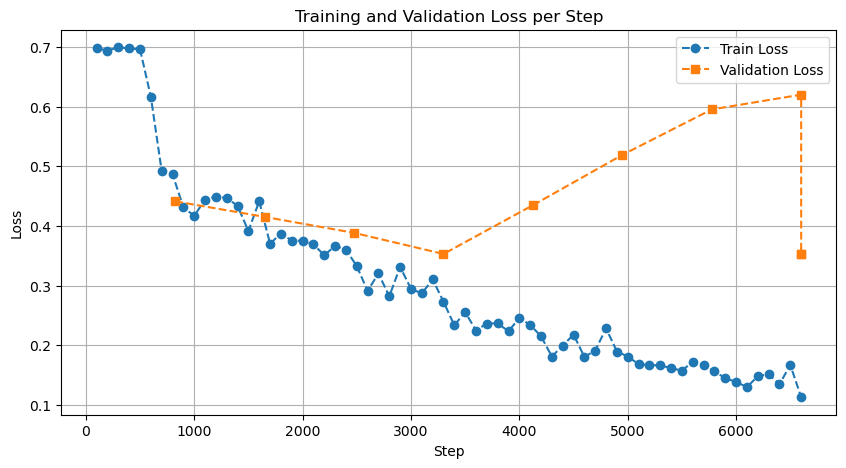

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
model_version = "subm2_newtokenizer_fullretrain"
output_dir = f"./{model_version}/checkpoints"
model_path = f"./{model_version}/model"
subm_path = f"./{model_version}/submission.csv"

VOCAB_SIZE = 30522
MIN_FREQUENCY = 2


def make_dataset(
    df,
    train=True,
):
    # Load tokenizer to get the separator token
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    sep_token = tokenizer.sep_token

    # Convert list of strings in 'ingredients' column to a single string
    df["ingredients"] = df["ingredients"].apply(
        lambda x: sep_token.join(eval(x)) if isinstance(x, str) else ""  # type: ignore
    )

    # Fill NaN values in 'description' with an empty string
    df["description"] = df["description"].fillna("")

    # Combine text columns with a separator
    def make_text(row):
        return f"""
    Name: {row['name']}
    {sep_token}
    Description: {row['description']}
    {sep_token}
    Ingredients: {row['ingredients']}
        """

    df["text"] = df.apply(make_text, axis=1)

    # df["text"] = "Ingredients: " + df["ingredients"]

    if train:
        # Convert boolean target column into 0/1 format
        df["vegetarian"] = df["vegetarian"].astype(int)

        # Convert to Hugging Face Dataset format
        dataset = Dataset.from_pandas(df[["text", "vegetarian"]])
    else:
        dataset = Dataset.from_pandas(df[["text"]])

    return dataset


# Step 1: Load Your Custom Dataset
file_path = "/kaggle/input/win25-stat-528-kaggle-competition-1/train.csv"
df = pd.read_csv(file_path)

dataset = make_dataset(df)


# Step 2: Load Pre-trained DistilBERT Model and Tokenizer
model_name = "distilbert-base-uncased"
# model_name = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2
)


def get_new_tokenizer():
    temp_file = Path("temp_tokenizer_train.txt")
    with temp_file.open("r", encoding="utf-8") as f:
        corpus = f.read().splitlines()

    # Train a new tokenizer using the Hugging Face Tokenizers library
    old_tokenizer = AutoTokenizer.from_pretrained(model_name)
    new_tokenizer = old_tokenizer.train_new_from_iterator(corpus, vocab_size=30520)  # type: ignore
    return new_tokenizer


tokenizer = get_new_tokenizer()
model.resize_token_embeddings(len(tokenizer))

for param in model.parameters():
    param.requires_grad = True  # Freeze all layers

for param in model.distilbert.embeddings.parameters():
    param.requires_grad = True


def tokenize_and_decode(text):
    """Tokenizes input text, prints token IDs, and decodes them back to text."""

    # Tokenize the input text
    encoded = tokenizer(text, return_tensors="pt")

    # Extract token IDs
    token_ids = encoded["input_ids"][0].tolist()  # type: ignore

    # Decode back to text
    decoded_text = tokenizer.decode(token_ids, skip_special_tokens=True)

    return {
        "original_text": text,
        "tokenized_words": tokenizer.tokenize(text),
        "token_ids": token_ids,
        "decoded_text": decoded_text,
    }


print(tokenize_and_decode("never put pineapple on a pizza"))


def tokenize_dataset(dataset, train=True):
    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=512,
        )

    # Tokenize dataset
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(
        ["text"]
    )  # Remove raw text
    if train:
        tokenized_dataset = tokenized_dataset.rename_column(
            "vegetarian", "labels"
        )  # Rename label column
    tokenized_dataset.set_format("torch")

    return tokenized_dataset


def make_submission(trainer, save_path):
    file_path = "/kaggle/input/win25-stat-528-kaggle-competition-1/test.csv"
    test_df = pd.read_csv(file_path)
    test_dataset = make_dataset(test_df, train=False)
    tokenized_test_dataset = tokenize_dataset(test_dataset, train=False)

    predictions = trainer.predict(tokenized_test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=-1)

    test_df["vegetarian"] = predicted_labels

    test_df[["id", "vegetarian"]].to_csv(save_path, index=False)


tokenized_dataset = tokenize_dataset(dataset)


# Split into train/test
split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
eval_dataset = split["test"]


# Split into train/test
split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = split["train"]
eval_dataset = split["test"]


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}


# --- Step 2: Define Training Callback for tqdm Progress Bar ---
class ProgressCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        print(f"Training started: {state.max_steps} steps in total.")

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Logs progress every 10 steps."""
        if logs is not None and "loss" in logs:
            tqdm.write(
                f"Step {state.global_step}/{state.max_steps}, Loss: {logs['loss']:.4f}"
            )


# --- Step 3: Define Training Arguments with Logging and TensorBoard Support ---
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,  # 最も良いモデルをロード
    metric_for_best_model="eval_loss",  # 評価指標として eval_loss を使用
    greater_is_better=False,  # loss は小さい方が良い
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    # num_train_epochs=1,
    weight_decay=0.04,
    logging_dir="./logs",  # For TensorBoard
    logging_steps=100,
    report_to=["tensorboard"],  # Log to TensorBoard
    save_total_limit=2,  # Keep only the last 2 checkpoints
    push_to_hub=False,
)


# --- Step 4: Initialize Trainer with Callback ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[ProgressCallback()],  # Custom progress callback
)

# --- Step 5: Train the Model ---
trainer.train()

# --- Step 6: Evaluate Model ---
trainer.evaluate()

# --- Step 7: Save Fine-tuned Model ---
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

trainer.evaluate()

plot_loss(trainer, model_version)

make_submission(trainer, subm_path)